# CS 7641
## Assignment 1 - Supervised Learning

Author: David Mattson

This file will explore supervised learning analysis and techniques on a dataset representing home prices in King County, Washington.

The analysis will focus on exploring different ways to represent data and ultimately the effects it has on the following five learning algorithms:

1. Decision Trees with pruning
2. Neural Networks
3. Boosting
4. Support Vector Machines
5. K-Nearest Neighbors

### Methodology
I am going to explore the effect of mutating a small portion of the data to see the effects it has on overall model quality.

Specifically, the data includes two columns of interest: latitude and longitude.  These columns are ultimately just geometric descriptors based upon an arbitrary geometric origin, which just so happens to lie about 400 miles off the coast of Central Africa, which doesn't sound too useful for homes in King County, Washington.

It seems we could probably improve these two features by using coordinate descriptors which are more applicable to the problem we are attempting to solve.











### Visualizing Data

Before we go any further, lets visualize our data

In [26]:
import matplotlib.pyplot as plt
import numpy
import matplotlib.ticker
from mytools.tools import printpp,zillowtime_to_timestamp,year_renovated_to_boolean
import pandas as pd
import seaborn as sns
def observe_data(df:pd.DataFrame)->None:

    #printpp("correlations:")
    sns.set(rc = {'figure.figsize':(5,15)})
    col_vec = df.corr()["price"].sort_values()
    col_vec = pd.DataFrame(col_vec)
    col_vec=col_vec.apply(lambda x: numpy.abs(x))
    sns.heatmap(col_vec, annot=True, cmap='YlGnBu')
def plot_features_vs_price(df:pd.DataFrame)->None:
    fig, axs = plt.subplots(5,4,figsize=(30,40),sharey=True)
    features=df.copy(deep=True)
    prices=features.pop("price")
    m=-1
    for i,col in enumerate(features):
        if i%5==0:
            m+=1
        if col!="price":
            rown=i%5
            coln=m%4
            axs[rown][coln].scatter(df[col], prices)
            axs[rown][coln].set_title(f"{col} vs Price")
            axs[rown][coln].set_xlabel(col)
            axs[rown][coln].set_ylabel("Price")
            Z = numpy.polyfit(df[col], prices, 1)
            slope=Z[0]
            y_int=Z[1]
            poly = numpy.poly1d(Z)
            axs[rown][coln].plot(df[col], poly(df[col]), '--r',label=f"{col} trend vs price: y={slope:.2f}x+{y_int:.2f}")
            axs[rown][coln].legend(loc='upper center')
    min_y_tick = prices.min()
    max_y_tick = prices.max() * 1.1
    plt.yticks(list(range(min_y_tick,int(max_y_tick),500000)))
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x}"))
    plt.show()
def scatter_features_subset_vs_price(df:pd.DataFrame, features:list)->None:
    fig, axs = plt.subplots(1,len(features),figsize=(15,5),sharey=True)
    c=0
    for _feature in features:
        axs[c].scatter(x=df[_feature], y=df["price"])
        axs[c].set_title(f"{_feature} vs Price")
        axs[c].set_xlabel(_feature)
        axs[c].set_ylabel("Price")
        Z = numpy.polyfit(df[_feature], df['price'], 1)
        slope,y_int = Z
        poly = numpy.poly1d(Z)
        axs[c].plot(df[_feature], poly(df[_feature]), '--r', label=f"Trendline: y={slope:.2f}x+{y_int:.2f}")
        axs[c].legend(loc='upper center')
        c+=1
    min_y_tick = df["price"].min()
    max_y_tick = df["price"].max() * 1.1
    plt.yticks(list(range(min_y_tick,int(max_y_tick),500000)))
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x}"))
    plt.show()


"""### Price to int for easy reading."""
converters={
    'price':lambda x: int(float(x)),
    "date":zillowtime_to_timestamp,
}



### Dataset1 - The Original Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  int64  
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

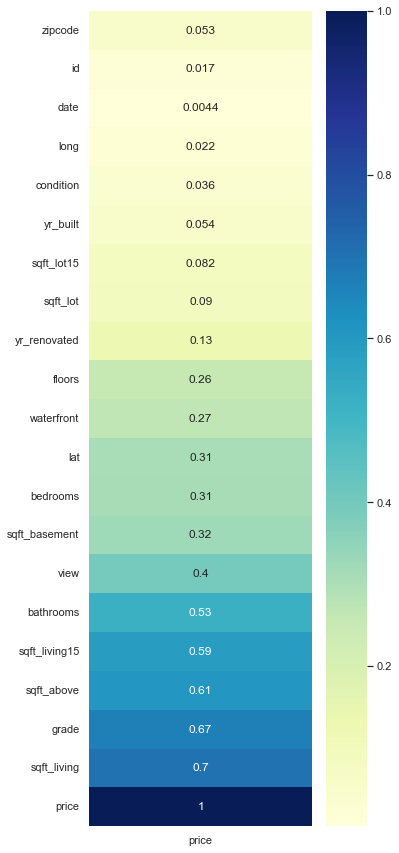

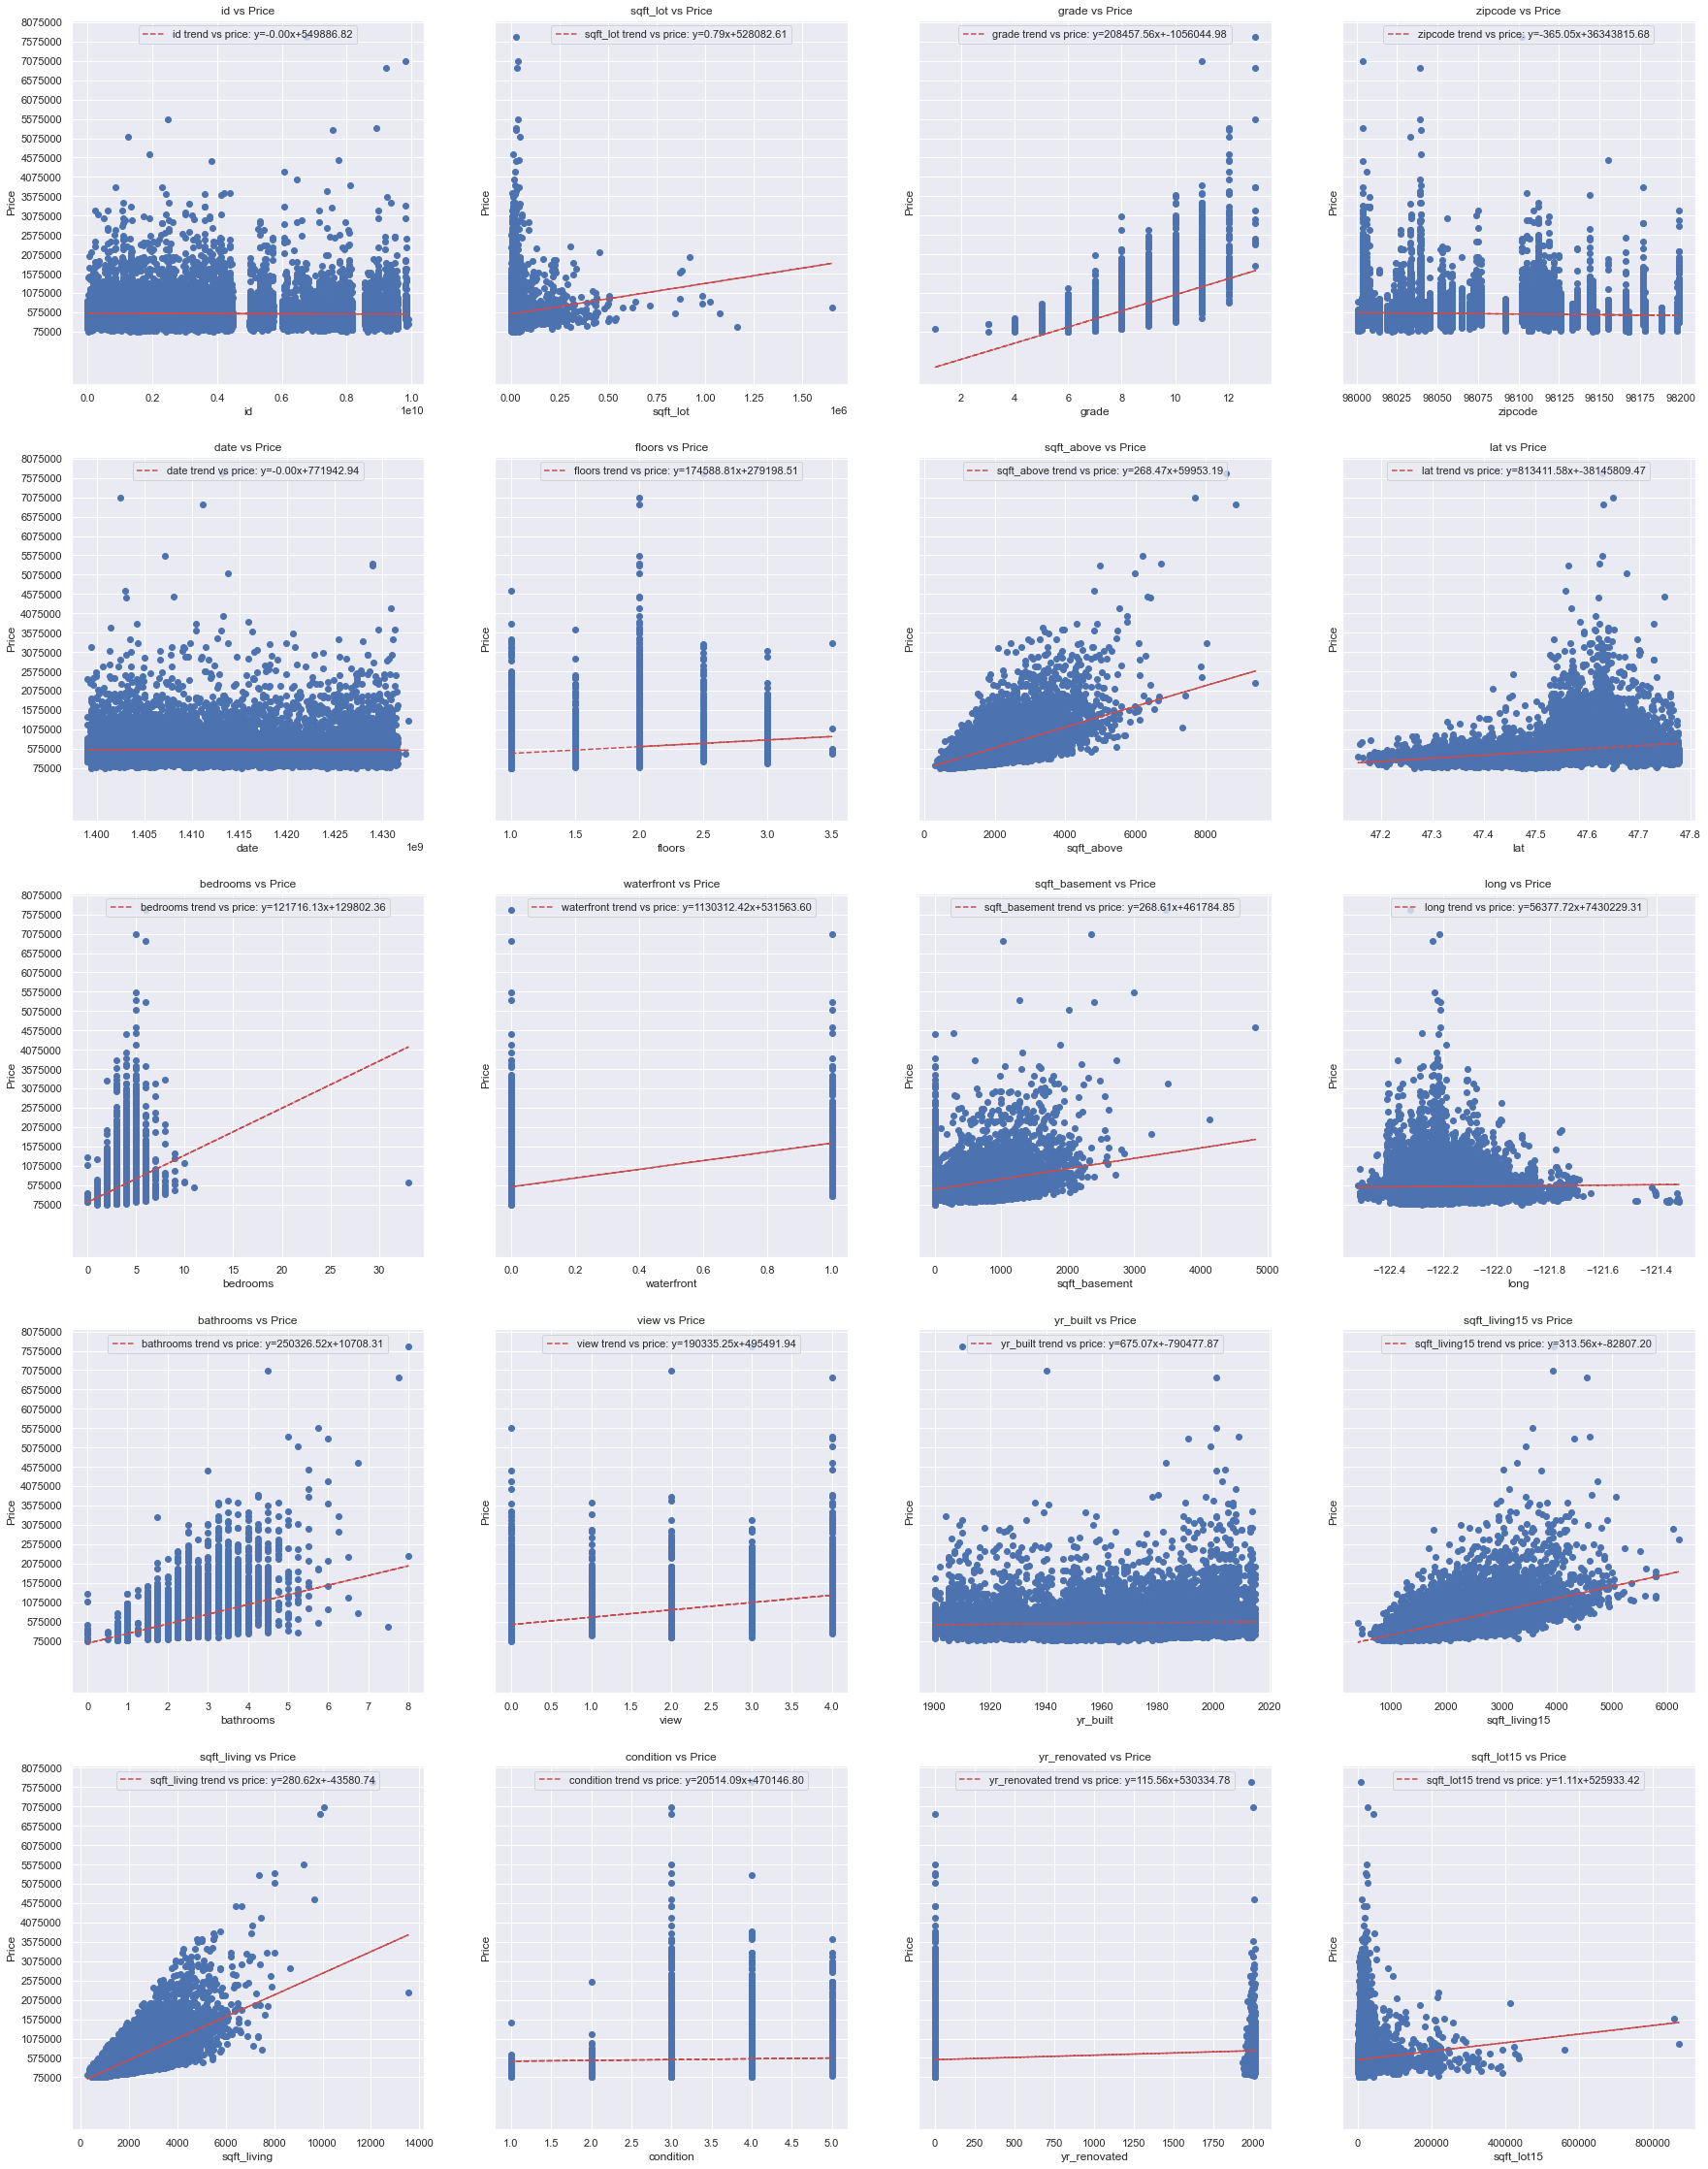

In [27]:
dataset1=pd.read_csv("data/kc_house_data.csv",converters=converters)

dataset1.info()
print(dataset1.head())
print(dataset1.describe())
observe_data(dataset1)
plot_features_vs_price(dataset1)







###  Dataset2 - Improving the Data

Lets knockout any poorly correlated features, tansform the zip to a ranking, and turn yr_renovated into something meaningful (right now its mostly the value '0' )



Drop these features with less than 0.1 pearson correlation:
 - id
 - date
 - condition
 - sqft_lot15
 - sqft_lot
 - yr_built
 - yr_renovated

The following feature seems useful but is represented poorly.  I will transform it:
 - zipcode -> Rank zip codes by price and use ranking value instead of the actual zipcode

Hold on to these for later (dont do anything on this data set with them):
 - lat
 - long




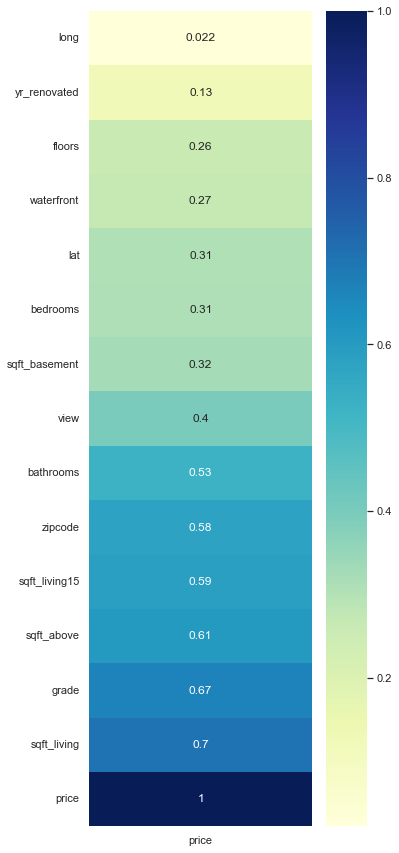

In [28]:
dataset2=pd.read_csv("data/kc_house_data.csv",converters=converters)
pd.options.mode.chained_assignment = None


"""###  replace zipcodes with a rank based on mean housing price for that zipcode... an int from 0 to len(zipcodes)-1"""
from operator import itemgetter

"""Drop features that done seem to be correlated to our target (we will leave lat and long for right now)"""
for feature in ("id","date","condition","sqft_lot15", "sqft_lot", "yr_built"):
    dataset2.pop(feature)

zipcode_mapping={pair[0]:i for i, pair in enumerate(sorted(dataset2.groupby("zipcode")["price"].mean().iteritems(), key=itemgetter(1)))}
dataset2['zipcode']=dataset2['zipcode'].transform(zipcode_mapping.get)



#printpp("Before Modification: ")
#scatter_features_subset_vs_price(dataset2,["yr_renovated","zipcode"])



"""Lets show just the altered features"""
#printpp("After Modification: ")
observe_data(dataset2)
#scatter_features_subset_vs_price(dataset2,["yr_renovated","zipcode"])






### Dataset3 - similar to dataset2 but also changing lat/lon to radial, centered at (mean(lat),mean(long)) -

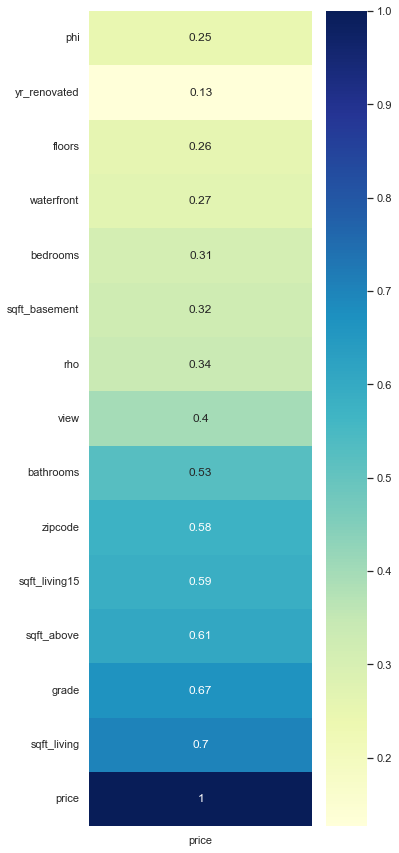

In [29]:
from numpy import sqrt, arctan2
"""Converts a normal cartesian coordinate pair to a polar coordinate pair in the form of (ρ,ɸ)"""
def convert_cartesian_to_polar(lat: float, lon: float) -> (float, float):
    return (sqrt(lat ** 2 + lon ** 2), arctan2(lat, lon))

dataset3=dataset2.copy(deep=True)


#scatter_features_subset_vs_price(dataset3,["lat","long"])


lat_index = list(dataset2.columns).index("lat")
long_index =  list(dataset2.columns).index("long")
lat_mean = dataset3["lat"].mean()
long_mean = dataset3["long"].mean()
dataset3["long"]=dataset3["long"].apply(lambda x: x-long_mean)  # shift longs to center at mean
dataset3["lat"]=dataset3["lat"].apply(lambda x: x-lat_mean)  # shift lats to center at mean
for index,row in dataset3.iterrows():
    lat = dataset3.iat[index, lat_index]
    long = dataset3.iat[index, long_index]
    phi,rho = convert_cartesian_to_polar(lat,long)
    dataset3.iat[index, lat_index] = phi
    dataset3.iat[index, long_index] = rho

dataset3.rename(
    inplace=True,
    columns={
        "lat":"phi",
        "long":"rho"
    }
)

observe_data(dataset3)
#scatter_features_subset_vs_price(dataset3,["phi","rho"])

### Dataset4 - Previous dataset, but trimming outliers +/- 5%

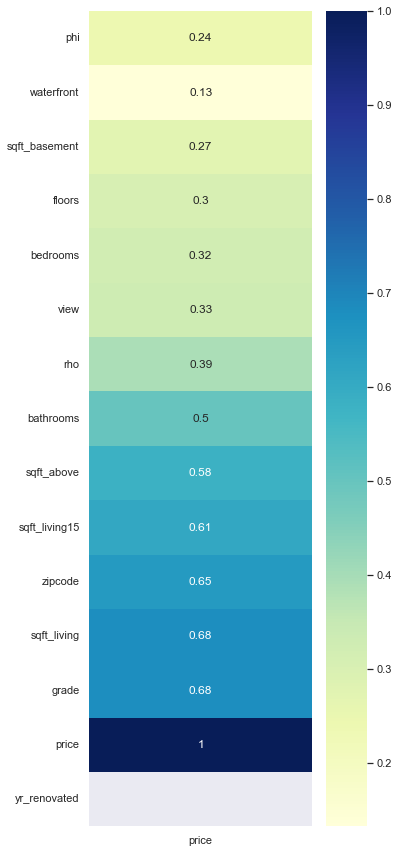

In [30]:
dataset4  =dataset3.copy(deep=True)

"""ngl i stole this: https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles"""

cols =['price', 'bedrooms', 'bathrooms', 'sqft_living',  'floors',
       'view','grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'phi', 'rho',
       'sqft_living15',"yr_renovated"]


Q1 = dataset4[cols].quantile(0.5) #lol i guess these are called vigintiles?
Q3 = dataset4[cols].quantile(0.95)
IQR = Q3 - Q1

dataset4 = dataset4[~((dataset4[cols] < (Q1 - 1.5 * IQR)) |(dataset4[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

#printpp("Look at final processed data: ")
observe_data(dataset4)
#plot_features_vs_price(dataset4)


### Dataset5 - dataset4, but lets cut out +/-20% of outliers.
Outliers bad. Noise bad.
Clarity good.

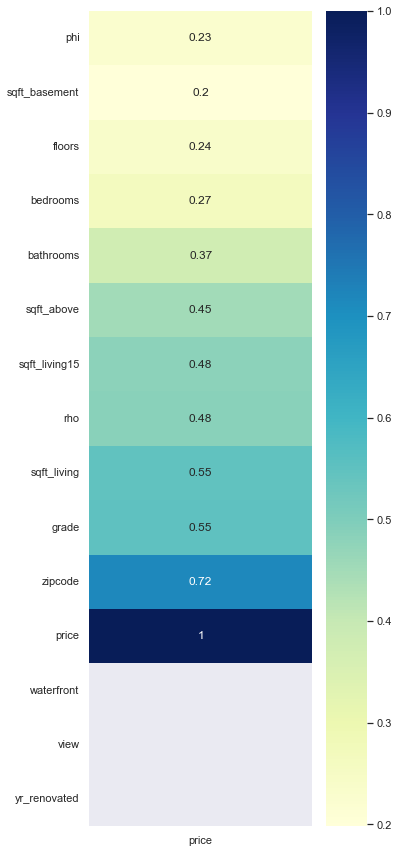

In [31]:
dataset5  =dataset3.copy(deep=True)

"""ngl i stole this: https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles"""

cols =['price', 'bedrooms', 'bathrooms', 'sqft_living',  'floors',
       'view','grade', 'sqft_above',
       'sqft_basement', 'zipcode', 'phi', 'rho',
       'sqft_living15',"yr_renovated"]


Q1 = dataset5[cols].quantile(0.20) #Quintiles, my firend.  Quintiles.
Q3 = dataset5[cols].quantile(0.80)
IQR = Q3 - Q1

dataset5 = dataset5[~((dataset5[cols] < (Q1 - 1.5 * IQR)) |(dataset5[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

#printpp("Look at final processed data: ")
observe_data(dataset5)
#plot_features_vs_price(dataset4)

### Getting our train test data together..

In [32]:
from sklearn.model_selection import train_test_split
train_test_data={}
i=1
for dataset in [dataset1,dataset2,dataset3,dataset4,dataset5]:
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('price',axis=1), dataset[["price"]])
    train_test_data.update({
        f"dataset{i}":{
            "X_train":X_train,"X_test":X_test,"y_train":y_train,"y_test":y_test
        }
    })
    i+=1

### Model1 - Decision Trees with pruning

In [33]:


from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import mean_absolute_error,mean_squared_error

import warnings
from sklearn.exceptions import DataConversionWarning,ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


def fit_model(model, model_name, key, value):
    global train_test_data
    print(f"training {model_name} using {key}")
    model.fit(value["X_train"],value["y_train"])
    y_predicted = model.predict(value["X_test"])
    mae=mean_absolute_error(value["y_test"], y_predicted.ravel())
    mse=mean_squared_error(value["y_test"], y_predicted.ravel(),squared=False)
    train_test_data[key][model_name]={
        "mse":mse,
        "mae":mae
    }

models={
    "decision_tree_regressor":DecisionTreeRegressor(),
    "multi-layer_perceptron_regressor":MLPRegressor(max_iter=200),
    "gradient-boosting_regressor": GradientBoostingRegressor(),
    "support_vector_regressor":SVR(),
    "knn_regressor":KNeighborsRegressor(n_neighbors=2)
}
for model_name,model in models.items():
    for key,value in train_test_data.items():
        fit_model(model, model_name, key, value)

training decision_tree_regressor using dataset1
training decision_tree_regressor using dataset2
training decision_tree_regressor using dataset3
training decision_tree_regressor using dataset4
training decision_tree_regressor using dataset5
training multi-layer_perceptron_regressor using dataset1
training multi-layer_perceptron_regressor using dataset2
training multi-layer_perceptron_regressor using dataset3
training multi-layer_perceptron_regressor using dataset4
training multi-layer_perceptron_regressor using dataset5
training gradient-boosting_regressor using dataset1
training gradient-boosting_regressor using dataset2
training gradient-boosting_regressor using dataset3
training gradient-boosting_regressor using dataset4
training gradient-boosting_regressor using dataset5
training support_vector_regressor using dataset1
training support_vector_regressor using dataset2
training support_vector_regressor using dataset3
training support_vector_regressor using dataset4
training support_ve

In [47]:
results=pd.DataFrame({
            "model_name":[],
            "dataset":[],
            "mse":[]
        })
for i in range(1,6):
    key=f"dataset{i}"
    for model_name in models.keys():
        mse=train_test_data[key][model_name]["mse"]
        results.loc[len(results.index)] = [model_name,int(key.replace("dataset","")),int(mse)]





In [54]:
results.sort_values(by=['mse']).groupby("model_name").head()

,model_name,dataset,mse
22,gradient-boosting_regressor,5.0,76996.0
17,gradient-boosting_regressor,4.0,101745.0
20,decision_tree_regressor,5.0,105592.0
7,gradient-boosting_regressor,2.0,119002.0
21,multi-layer_perceptron_regressor,5.0,121788.0
12,gradient-boosting_regressor,3.0,127136.0
2,gradient-boosting_regressor,1.0,133532.0
15,decision_tree_regressor,4.0,142113.0
24,knn_regressor,5.0,154926.0
5,decision_tree_regressor,2.0,173162.0
